In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

In [2]:
def convert_volume(value):
    if pd.isna(value) or value == '-': return 0.0
    value = str(value).upper()
    try:
        if 'K' in value: return float(value.replace('K', '').replace(',', '')) * 1000
        if 'M' in value: return float(value.replace('M', '').replace(',', '')) * 1000000
        return float(value.replace(',', ''))
    except: return 0.0

def load_and_clean_data():
    df_gold = pd.read_csv('Gold Price (2013-2023).csv')
    df_gold['Date'] = pd.to_datetime(df_gold['Date'])
    for col in ['Price', 'Open', 'High', 'Low']:
        df_gold[col] = df_gold[col].astype(str).str.replace(',', '').astype(float)
    df_gold['Vol.'] = df_gold['Vol.'].apply(convert_volume)
    df_gold = df_gold.sort_values('Date').drop_duplicates('Date').set_index('Date')

    df_market = pd.read_csv('final_data.csv')
    df_market['Date'] = pd.to_datetime(df_market['Date'], dayfirst=True)
    for col in ['USO', 'SLV', 'S&P500', 'EUR/USD']:
        if df_market[col].dtype == 'object':
            df_market[col] = df_market[col].astype(str).str.replace(',', '').astype(float)
    df_market = df_market.sort_values('Date').drop_duplicates('Date').set_index('Date')

    df_fed = pd.read_csv('FEDFUNDS.csv').rename(columns={'observation_date':'Date'}).set_index('Date')
    df_fed.index = pd.to_datetime(df_fed.index)
    df_cpi = pd.read_csv('CORESTICKM159SFRBATL.csv').rename(columns={'observation_date':'Date'}).set_index('Date')
    df_cpi.index = pd.to_datetime(df_cpi.index)
    
    return df_gold, df_market, df_fed, df_cpi

In [3]:
df_gold, df_market, df_fed, df_cpi = load_and_clean_data()
full_idx = pd.date_range(start=df_gold.index.min(), end=df_gold.index.max(), freq='D')

df = df_gold.reindex(full_idx).ffill().join([df_market.reindex(full_idx).ffill(), 
                                             df_fed.reindex(full_idx).ffill(), 
                                             df_cpi.reindex(full_idx).ffill()])
df['Real_Rate'] = df['FEDFUNDS'] - df['CORESTICKM159SFRBATL']

# Thêm Indicators
features_to_log = ['Price', 'S&P500', 'SLV', 'USO', 'EUR/USD']
for col in features_to_log:
    df[f'{col}_LogRet'] = np.log(df[col] / df[col].shift(1))
df['RSI'] = 100 - (100 / (1 + (df['Price'].diff().where(df['Price'].diff() > 0, 0).rolling(14).mean() / 
                               -df['Price'].diff().where(df['Price'].diff() < 0, 0).rolling(14).mean())))
df['SMA_20'] = df['Price'].rolling(20).mean()
df['Volatility'] = df['Price_LogRet'].rolling(21).std()
df = df.dropna()

# Chọn Feature
feature_cols = ['Price_LogRet', 'S&P500_LogRet', 'SLV_LogRet', 'EUR/USD', 'Real_Rate', 'RSI', 'SMA_20', 'Volatility']
data_values = df[feature_cols].values
prices_values = df['Price'].values
dates_values = df.index

In [4]:
train_size = int(len(data_values) * 0.9)
train_data = data_values[:train_size]
test_data = data_values[train_size:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

n_steps_in = 90
n_steps_out = 7

# Tạo chuỗi train
def create_sequences(data, n_in, n_out):
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i : i + n_in, :])
        y.append(data[i + n_in : i + n_in + n_out, :])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, n_steps_in, n_steps_out)
train_data

array([[ 5.16114691e-03,  1.00289752e-02,  1.11075954e-02, ...,
         4.14872798e+01,  1.67528000e+03,  5.68928557e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.14872798e+01,  1.67573000e+03,  5.68928557e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.14872798e+01,  1.67574000e+03,  5.68928557e-03],
       ...,
       [ 7.90127567e-03, -2.61920128e-03,  7.93469741e-03, ...,
         6.69398907e+01,  1.80128000e+03,  5.81387938e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.69398907e+01,  1.80352500e+03,  5.81387938e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.69398907e+01,  1.80559500e+03,  5.81387938e-03]],
      shape=(3258, 8))

In [5]:
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=False), input_shape=(n_steps_in, len(feature_cols))),
    Dropout(0.2),
    RepeatVector(n_steps_out),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(len(feature_cols)))
])
model.compile(optimizer='adam', loss='huber')

print("Đang huấn luyện trên 90% dữ liệu...")
model.fit(X_train, y_train, epochs=80, batch_size=32, verbose=1, 
          callbacks=[EarlyStopping(monitor='loss', patience=10)])

Đang huấn luyện trên 90% dữ liệu...
Epoch 1/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.2027
Epoch 2/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1695
Epoch 3/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1603
Epoch 4/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.1553
Epoch 5/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.1525
Epoch 6/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1496
Epoch 7/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.1469
Epoch 8/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.1449
Epoch 9/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.1427
Epoch 10/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.1404
Epoch 11/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.1391
Epoch 12/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1374
Epoch 13/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.1364
Epoch 14/80
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.1361
Epoch 15/80
99/99 ━━━━━━━━━━━━━

In [6]:
all_forecasted_prices = []
actual_prices_to_compare = []
forecast_dates = []

full_scaled_data = np.vstack([train_scaled, test_scaled])

for i in range(train_size, len(full_scaled_data) - n_steps_out + 1, n_steps_out):
    input_window = full_scaled_data[i - n_steps_in : i, :]
    input_window = input_window.reshape((1, n_steps_in, len(feature_cols)))
    
    pred_7d_scaled = model.predict(input_window, verbose=0).reshape(n_steps_out, len(feature_cols))
    pred_7d = scaler.inverse_transform(pred_7d_scaled)

    last_actual_price = prices_values[i-1]
    temp_price = last_actual_price
    for j in range(n_steps_out):
        log_ret = pred_7d[j, 0]
        temp_price = temp_price * np.exp(log_ret)
        all_forecasted_prices.append(temp_price)
        actual_prices_to_compare.append(prices_values[i + j])
        forecast_dates.append(dates_values[i + j])

Directional Accuracy: 34.73%

KẾT QUẢ WALK-FORWARD (MỖI 7 NGÀY CẬP NHẬT REAL DATA)
RMSE: 34.03
MAPE: 1.51%


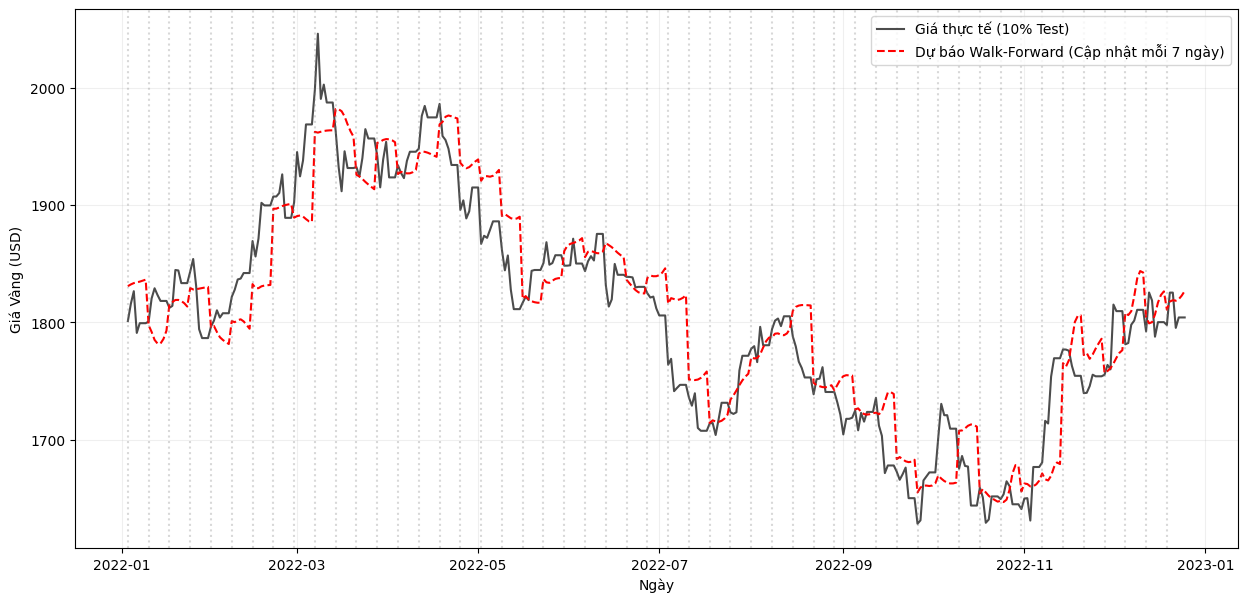

In [7]:
rmse = np.sqrt(mean_squared_error(actual_prices_to_compare, all_forecasted_prices))
mape = mean_absolute_percentage_error(actual_prices_to_compare, all_forecasted_prices) * 100
# --- Tính toán Directional Accuracy (DA) ---
def calculate_da(actual, forecast, prices_original, train_size, n_out):
    da_scores = []
    
    # Duyệt qua từng khối 7 ngày trong tập test
    # Lưu ý: Chúng ta cần so sánh ngày đầu tiên của chu kỳ với ngày cuối cùng của chu kỳ trước đó
    idx = 0
    for i in range(train_size, len(prices_original) - n_out + 1, n_out):
        # Lấy giá thực tế của ngày ngay trước chu kỳ dự báo
        prev_actual = prices_original[i-1]
        
        for j in range(n_out):
            # Hướng thực tế: Giá thực tế ngày j so với giá thực tế ngày (j-1)
            actual_dir = np.sign(actual[idx] - prev_actual)
            
            # Hướng dự báo: Giá dự báo ngày j so với giá thực tế ngày (j-1)
            # (Vì mô hình muốn dự đoán bước tiếp theo dựa trên thực tế đã biết)
            pred_dir = np.sign(forecast[idx] - prev_actual)
            
            da_scores.append(actual_dir == pred_dir)
            
            # Cập nhật prev_actual để so sánh cho ngày kế tiếp trong chu kỳ 7 ngày
            prev_actual = actual[idx]
            idx += 1
            
    return np.mean(da_scores) * 100

da_value = calculate_da(actual_prices_to_compare, all_forecasted_prices, prices_values, train_size, n_steps_out)

print(f"Directional Accuracy: {da_value:.2f}%")
print("\n" + "="*50)
print(f"KẾT QUẢ WALK-FORWARD (MỖI 7 NGÀY CẬP NHẬT REAL DATA)")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print("="*50)

plt.figure(figsize=(15, 7))
plt.plot(forecast_dates, actual_prices_to_compare, label='Giá thực tế (10% Test)', color='black', alpha=0.7)
plt.plot(forecast_dates, all_forecasted_prices, label='Dự báo Walk-Forward (Cập nhật mỗi 7 ngày)', color='red', linestyle='--')

# Vẽ các vạch đứng phân tách các chu kỳ 7 ngày
for d in forecast_dates[::7]:
    plt.axvline(x=d, color='gray', linestyle=':', alpha=0.3)

plt.xlabel("Ngày")
plt.ylabel("Giá Vàng (USD)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()